In [31]:
import os
import cv2
from jiwer import cer
import pytesseract
import numpy as np
import imutils

import re

from PIL import Image

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Configuration for tesseract
config = ('-l eng --oem 1 --psm 6')
    
# Implement this function that will return a string representing what in seen in the given image
def get_plate_text(img) -> str:
    
    img = imutils.resize(img, width=500)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
    gray = cv2.bilateralFilter(gray, 11, 17, 17) #Blur to reduce noise
    
#     gray = cv2.Sobel(img, cv2.CV_8F, dx=0, dy=1, ksize=3)
    
#     gray = cv2.medianBlur(gray,5)
    
    med_val = np.median(gray) 
    lower = int(max(0 ,0.7*med_val))
    upper = int(min(255,1.3*med_val))
    
    edged = cv2.Canny(gray, lower, upper)
    
    try:
        
        cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
        screenCnt = None

        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                screenCnt = approx
                break

        mask = np.zeros(gray.shape,np.uint8)
        new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
        new_image = cv2.bitwise_and(image,image,mask=mask)

        (x, y) = np.where(mask == 255)
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        Cropped = gray[topx:bottomx+1, topy:bottomy+1]

        

        # Run tesseract OCR on image
        text = pytesseract.image_to_string(Cropped, config=config)
        
    except:
        
        
        text = pytesseract.image_to_string(gray, config=config)
    
    return text

In [39]:
import os
import cv2
from jiwer import cer
import pytesseract
import numpy as np
import imutils





import re

from PIL import Image

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Configuration for tesseract
config = ('-l eng --oem 1 --psm 6')
    
# Implement this function that will return a string representing what in seen in the given image
def get_plate_text(img) -> str:
    
#     gray_car_image = img * 255
    gray_car_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_value = threshold_otsu(gray_car_image)
    gray = gray_car_image > threshold_value
    
    text = pytesseract.image_to_string(gray, config=config)
    
    return text

In [25]:
import os
import cv2
from jiwer import cer
import pytesseract
import numpy as np
import imutils

import re

from skimage.filters import threshold_otsu

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Configuration for tesseract
config = ('-l eng --oem 1 --psm 7')
    
# Implement this function that will return a string representing what in seen in the given image
def get_plate_text(img) -> str:
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gray = cv2.bilateralFilter(gray, 11, 17, 17) #Blur to reduce noise
    
    med_val = np.median(gray) 
    lower = int(max(0 ,0.7*med_val))
    upper = int(min(255,1.3*med_val))
    
    edged = cv2.Canny(gray, lower, upper)
    
    contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
    screenCnt = None

    for c in contours:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        if len(approx) == 4:
            screenCnt = approx
            break
            
    if screenCnt is not None:
        mask = np.zeros(gray.shape,np.uint8)
        new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
        new_image = cv2.bitwise_and(img,img,mask=mask)

        (x, y) = np.where(mask == 255)
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        Cropped = gray[topx:bottomx+1, topy:bottomy+1]

        temp = pytesseract.image_to_string(Cropped, config=config)
        
        if len(temp) >= 4:
            text = temp
        else:
            text = pytesseract.image_to_string(gray, config=config)
        
    else:
        
        text = pytesseract.image_to_string(gray, config=config)
    
    return text

In [26]:
img_dir = "plate_images/"
number_of_plates = 0
error = 0.0
# Loops through the given directory reading images in
for filename in os.listdir(img_dir):
    # Loads the image feel free to do this using whatever library you like opencv as an example
    img = cv2.imread(os.path.join(img_dir, filename), cv2.IMREAD_COLOR)
    
    # Gets the actual from the file name
    actual = filename.split("_")[0]
    guess = get_plate_text(img)
    
    
    pattern = r'[A-Z0-9]+'

    matches = re.findall(pattern, guess)
    merged_string = ''.join(matches)
    
    print(f"{actual[:-4]} : {merged_string}")

    
    # This is one way to get the error of the guess compared to actual feel free to evaluate your algorithm differently
    error += cer(actual[:-4], merged_string)
    number_of_plates += 1

accuracy = (1 - error/number_of_plates) * 100
print("Overall accuracy: ", accuracy)

001YDU : R01YOUR
00MEG : 
06TROY : 06TROY
084727 : ED
09GLEN : LOSCLEN
1094 : 1094
1707MO : 
1EH6RL : HMI
1FY3SO : 
1IC2NB : 111C2NB
1JY1VP : 
1NI6VM : 
1PA4PY : PAZ4PY
1QC6DA : 
1QUIT : 1QUIT
1TC3VD : 
1TS9XK : 1T5Y9XK
1UK3PP : 
1UR6WQ : JIURTEHOL
1VL8EX : VBE
1VU3KJ : JIVIT3K
1WA5CA : WATSCA
217816 : 
241CC6 : 241CCH
320XOR : 
324WMS : 
482TT : 48217
55TEW : 55TEW
5959MO : 5959WO
8362TT : 8362TT
867130 : 
90990 : 90990
909GRN : 909GRN
9310MO : 9310W
994EK6 : 
A023ZZ : ER
A71890 : B
AC19HD : IAC1D
AF44AB : F218
AJN703 : A7
AJV11X : 11
AK18NP : K884
AK22QC : 
AO23ZZ : 102377
AOG52E : AOG52F
AOW65Y : 
AP063 : 
AQ94NZ : WERE
AQG52E : 0081
AR971 : AR971
ARB098 : 
ARUNDEL : 
ATS09H : 
AU08ZN : AT082N
AUC84B : AUC848
AUD007 : AUD007
AY02TE : AY02T
AYAD18R : AVAD16R
AYAD546 : AYAD54G
B3SSIE : B3SSIE
BBI16A : HET16A
BC07FJ : 
BC35SU : BC35SU
BC64ZX : BC64Z
BE84LL : 041
BF87CF : JF67CF
BG35SU : BE3550
BI26AJ : 
BJ88PZ : BJ867
BJB14D : BJB
BJB61K : BJB61K
BJM169 : WT
BKC15G : LBKC15
BLJ34D : BL

In [29]:
actual.split(".")[0]

'YLT72Z'

In [8]:
img = cv2.imread(os.path.join(img_dir, "001YDU.jpg"))

In [12]:
for filename in os.listdir(img_dir):
    print(filename)

.ipynb_checkpoints
001YDU.jpg
00MEG.jpg
06TROY.jpg
084727.jpg
09GLE.jpg
1094.jpg
1707MO.jpg
1EH6RL.jpg
1FY3SO.jpg
1IC2NB.jpg
1JY1VP.jpg
1NI6VM.jpg
1PA4PY.jpg
1QC6DA.jpg
1QUIT.jpg
1TC3VD.jpg
1TS9XK.jpg
1UK3PP.jpg
1UR6WQ.jpg
1VL8EX.jpg
1VU3KJ.jpg
1WA5CA.jpg
217816.jpg
241CC6.jpg
320XOR.jpg
324WMS.jpg
482TT.jpg
55TEW.jpg
5959MO.jpg
8362TT.jpg
867130.jpg
90990.jpg
909GRN.jpg
9310MO.jpg
994EK6.jpg
A023ZZ.jpg
A71890.jpg
AC19HD.jpg
AF44AB.jpg
AJN703.jpg
AJV11X.jpg
AK18NP.jpg
AK22QC.jpg
AO23ZZ.jpg
AOG52E.jpg
AOW65Y.jpg
AP063.jpg
AQ94NZ.jpg
AQG52E.jpg
AR971.jpg
ARB098.jpg
ARUNDEL.jpg
ATS09H.jpg
AU08ZN.jpg
AUC84B.jpg
AUD007.jpg
AY02TE.jpg
AYAD18R.jpg
AYAD546.jpg
B3SSIE.jpg
BBI16A.jpg
BC07FJ.jpg
BC35SU.jpg
BC64ZX.jpg
BE84LL.jpg
BF87CF.jpg
BG35SU.jpg
BI26AJ.jpg
BJ88PZ.jpg
BJB14D.jpg
BJB61K.jpg
BJM169.jpg
BKC15G.jpg
BLJ34D.jpg
BMY36H.jpg
BNU40W.jpg
BPF235.jpg
BPI57A.jpg
BR0345.jpg
BR05CY.jpg
BRQ200.jpg
BS09UX.jpg
BSN24B.jpg
BT03WN.jpg
BT92UK.jpg
BTT79B.jpg
BU16MI.jpg
BVQ66W.jpg
BWX13N.jpg
BX49CN.jp

In [88]:
len(text)

0

In [48]:
gray_car_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
threshold_value = threshold_otsu(gray_car_image)
gray = gray_car_image > threshold_value

In [50]:
from matplotlib import pyplot as plt

In [54]:
med_val = np.median(gray) 
lower = int(max(0 ,0.7*med_val))
upper = int(min(255,1.3*med_val))

edged = cv2.Canny(gray, 30, 180)

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'Canny'
> Overload resolution failed:
>  - image data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'image'
>  - Canny() missing required argument 'threshold2' (pos 4)
>  - Canny() missing required argument 'threshold2' (pos 4)


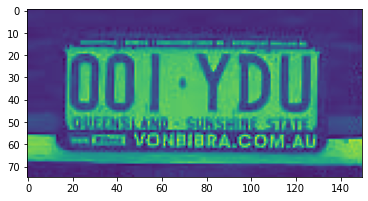

In [52]:
plt.imshow(gray_car_image)

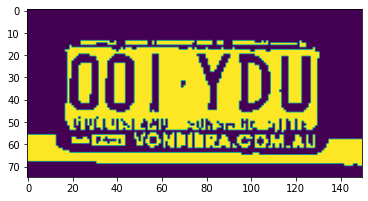

In [51]:
plt.imshow(gray)